<a href="https://colab.research.google.com/github/konan-91/OcularClassification/blob/master/notebooks/1_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#WORK IN PROGRESS! Please check back later.

#Generating Topoplots from Blinks

Our first step is to transform the dataset of ocular & non-ocular EEG data into spectograms (image files) that we can use to train the model.

In [1]:
!pip install mne -q
!pip install pymatreader -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 43.9 MB/s eta 0:00:00


In [2]:
import mne
import pymatreader
import matplotlib.pyplot as plt
import numpy as np
import os

##Loading the data

Note: if you are running this notebook yourself, please ensure the zipped osf dataset is present at the root of your working directory. In Colab, this is /content.

In [3]:
!unzip -q /content/osfstorage-archive.zip
!rm /content/osfstorage-archive.zip

In [4]:
def load_data(folderpath, data):
    for filename in os.listdir(folderpath):
        if filename.endswith(".set"):
            filepath = os.path.join(folderpath, filename)
            epochs = mne.read_epochs_eeglab(filepath) # The dataset we use comes pre-epoched
            data.append(epochs)

In [ ]:
#mne.set_log_level('ERROR')
path = "/content/osfstorage-archive"
participantsData = [] # List of participants, who are objects containing (many) epochs

for study in os.listdir(path):
    study_path = os.path.join(path, study)
    if os.path.isdir(study_path):
        load_data(study_path, participantsData)

###Understading the Dataset

Participants were asked to rest, blink, and make horizontal and vertical eye movements. As such, the dataset contains labelled and timestamped data of when each event occured. Labelled data is ideal for training classification models, as we can teach it to accurately disciminate between each event.

The OSF training dataset is split into 5 studies. Each study contains EEGLAB objects which represent each participant in the study. Each object is a collection of epochs, containing rest events, blinks, or saccades. Each epoch may contain anywhere from 6-20 events of *only* one of the prior listed event types. In order to maximise the amount of training data, we need to split the data so that each individual event has it's own epoch (ex. each blink is its own epoch, rather than an epoch containing 6+ blinks).

In [42]:
blinksData = [participant['4'] for participant in participantsData]
blinkTriggerData = [participant.get_data(picks='eye-blink') for participant in blinksData]

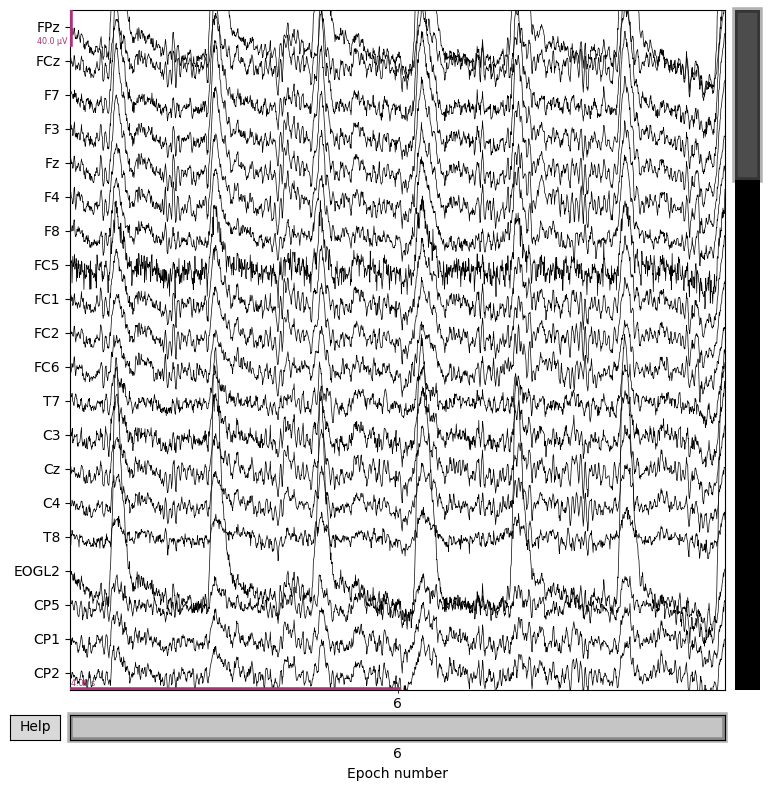

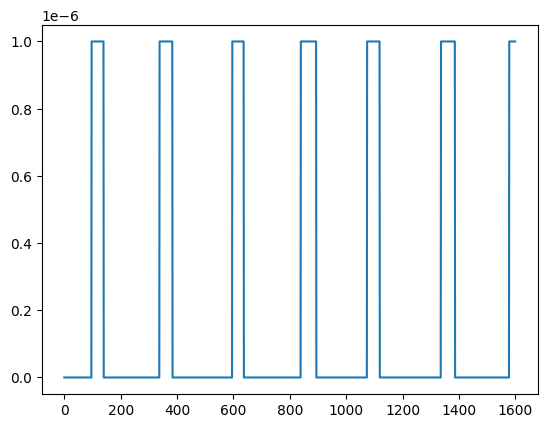

In [44]:
blinksData[0][0].plot()

plt.plot(blinkTriggerData[0][0].T)
plt.show()

In [ ]:
'''
participant_1 = participants_data[0]
print(participant_1.event_id)

blinks_1 = participant_1['4'] # Filter for blink epochs only
print(blinks_1.event_id)

# SPECIFIC CHANNELS ONLY!
blinks_1[0].plot(picks=['eye-blink', 'C3', 'C4', 'FPz', 'FCz', 'F7', 'F3', 'Fz', 'F4', 'FC5', 'FC1', 'FC2', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2])

binary_data = blinks_1.get_data(picks='eye-blink')
blinks_1[0].plot()

plt.plot(binary_data[0].T)  # Transpose to plot time on the x-axis
plt.xlabel('Time Points')
plt.ylabel('Blink (1=Yes, 0=No)')
plt.title('Binary Channel for Eye Blink (Epoch 1)')
plt.show()
'''